## Imports & Helpers

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')
from checkmate_imports import *

# global variables 
HUE_ORDER = ['stroma','pred_g2','intermediate_grade','pred_g4']
MIN_SEGMENT_SIZE = 50
GRADE_DIFF_THRESH = 0.35
TUMOR_DIFF_THRESH = 0.35
MIN_TUMOR_SEG_MEAN = 0.70
NODE_DIFF_CUTOFF = invert_rag_weight(GRADE_DIFF_THRESH) 
MIN_TIL_COUNT = 10

# GRADE_TC_CUTOFF = 0.4  # minimum segment mean grade score to consider in TIL processing 
# GRADE_TC_CUTOFF = 0.  # minimum segment mean grade score to consider in TIL processing 
GRADE_TC_CUTOFF = 0.8  # focusing on high grade foci only 

print('MODIFYING EARLIER TIL CUTOFFS')
TIL_ISO_CUTOFF = 14  # based on none vs any AUROC bootstrap on high grade foci + no hard cases
TIL_HIGH_CUTOFF = 48 # based on not-high vs high AUROC bootstrap on high grade foci + no hard cases
FRAC_CUTOFF = 0.25
TIL_AREA_CUTOFF = 10

EXCLUSION_RATIO_CUTOFF = 1.5  # margin vs center ratio threshold for "exclusion" call
TILES_PER_MM2 = 0.256**-2

# assume 7x7 minimum case for a square area focus
# going 2 tiles inner would result in a 5x5 inner cube and thus area cutoff of 25
# MIN_CENTER_AREA = 25
MIN_CENTER_AREA = 10  # relaxing from 25 to try to recover possible interesting foci

MODIFYING EARLIER TIL CUTOFFS


In [4]:
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
from itertools import combinations, product

In [5]:
# feature_subset = pd.read_csv('../rerun_final_patient_features.csv', index_col=0)
feature_subset = pd.read_csv('/home/jupyter/checkmate-histo/consolidated_workflow/tcga_ricketts_rerun/rerun_final_patient_features_RICKETTS_FILTER.csv', index_col=0)

anno = pd.read_csv('../manual_cm025_merged_braunsupp_annotations.csv') 
anno['unique_id'] = 'cm025_' + anno.subjid.astype(str)
paper_desert = anno.loc[anno.ImmunoPhenotype == 'Desert','unique_id'].values
paper_infl = anno.loc[anno.ImmunoPhenotype == 'Infiltrated','unique_id'].values
paper_excl = anno.loc[anno.ImmunoPhenotype == 'Excluded','unique_id'].values
anno = anno.set_index('unique_id')

node_descriptions = pd.read_csv('../rerun_node_descriptions_with_score_components.csv',index_col=[0])
node_descriptions['merged_labels'] = node_descriptions['merged_labels'].astype(int)

prox_dist_edges = pd.read_csv('../rerun_proximal_and_distal_edge_annotations_with_score_components.csv',index_col=0)

scores = pd.read_csv('../rerun_slidewise_grade_til_scores.csv', index_col=0)

load_tile_info = False

if load_tile_info:
    tilewise_anno = pd.read_csv('../rerun_tilewise_grade_til_annotations.csv', index_col=0) # TIL specific CM025 subset

    edge_info = pd.read_csv('../rerun_base_rag_edge_info_annotation.csv', index_col=[0,1,2,3])
    # restore set objects (stored as string when saved to csv earlier)
    edge_info['edge_set'] = edge_info.reset_index()[['edge0','edge1']].apply(lambda x: set(x),1).values

    # read in non-TIL tilewise info 
    seg_agg = pd.read_csv('../rerun_tilewise_grade_nontil_annotations.csv', index_col=0)
    
    edge_agg_pivot = pd.read_csv('../rerun_base_rag_edge_info_annotation_processed.csv', index_col=[0,1,2])
    edge_class_sum = pd.read_csv('../rerun_base_rag_edge_info_annotation_processed_sum.csv', index_col=0)
    edge_binary = edge_class_sum > 0

### Override previous infiltration cutoffs to simply be based on median 

In [6]:
prev = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['os', 'os_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 148)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 149)
dropping low tumor tile count cases
(558, 149)
dropping G1 [keeping unannotated cases]
(557, 149)
dropping metastatic biopsies
(439, 149)
keeping all stages 
(439, 149)
only keeping cases MSKCC risk group annotation
(439, 150)
converting bool edge presence labels to string


In [7]:
prev['all_nodes_area_weighted'].dropna().median()

0.1585503963759909

In [8]:
prev.groupby(['global_infiltration_bin'])['all_nodes_area_weighted'].describe()

,count,mean,std,min,25%,50%,75%,max
global_infiltration_bin,,,,,,,,
high_hg_global_infiltration,176.0,0.370849,0.247098,0.057034,0.157776,0.337544,0.543110,0.969733
low_hg_global_infiltration,87.0,0.017764,0.016090,0.000000,0.004593,0.013818,0.030297,0.055446
no_hg_present,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
MEDIAN_HG_INF_CUTOFF = 0.15855
print(f'Setting Area Infiltration Cutoff to be {MEDIAN_HG_INF_CUTOFF} based on Median')

Setting Area Infiltration Cutoff to be 0.15855 based on Median


In [10]:
crit = (feature_subset['cohort'] == 'cm025') & (feature_subset['usable_til_data']) & (feature_subset['all_nodes_area_weighted'] < MEDIAN_HG_INF_CUTOFF)

In [11]:
feature_subset.loc[crit, 'global_infiltration_bin'] = 'low_hg_global_infiltration'

In [12]:
update = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['os', 'os_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 148)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 149)
dropping low tumor tile count cases
(558, 149)
dropping G1 [keeping unannotated cases]
(557, 149)
dropping metastatic biopsies
(439, 149)
keeping all stages 
(439, 149)
only keeping cases MSKCC risk group annotation
(439, 150)
converting bool edge presence labels to string


In [13]:
update.groupby(['global_infiltration_bin'])['all_nodes_area_weighted'].describe()

,count,mean,std,min,25%,50%,75%,max
global_infiltration_bin,,,,,,,,
high_hg_global_infiltration,132.0,0.459134,0.223431,0.15855,0.248671,0.400099,0.619838,0.969733
low_hg_global_infiltration,131.0,0.047398,0.046386,0.00000,0.008805,0.030429,0.087560,0.155452
no_hg_present,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
NONKM_FONT_SCALE = 1.8
KM_FONT_SCALE = 1.2

### Fig 1: ROC Curve KIRC G2 vs G4

In [15]:
# from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, roc_curve, confusion_matrix, plot_confusion_matrix

# temp = feature_subset.loc[(feature_subset.cohort =='kirc') & (feature_subset.grade.isin(['G2','G4']))]
# print(temp.shape)
# temp = temp.loc[~temp['nonstroma_grade_mean'].isna()]
# print(temp.shape)
# temp['g4_not_g2'] = (temp.grade == 'G4').astype(int)
# temp['slide_pred'] = (temp['nonstroma_grade_mean'] > 0.5).astype(int)
# temp['correct_slide_pred'] = temp['g4_not_g2'] == temp['slide_pred']
# temp['correct_slide_pred'].mean()

# score = roc_auc_score(temp['g4_not_g2'], temp['nonstroma_grade_mean'])
# fpr, tpr, thresh =  roc_curve(temp['g4_not_g2'], temp['nonstroma_grade_mean'])

# set_rc(8,8, NONKM_FONT_SCALE)

# plt.plot(fpr, tpr, label=f'AUROC {score:.3f}', linewidth=5)
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.title('TCGA-KIRC \n G2 vs G4')
# plt.legend(loc='lower right')
# plt.savefig('./main_figs/kirc_auroc.pdf', bbox_inches='tight')
# plt.show()

### Fig 1: Grade Score by Cohort 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TCGA-KIRC_G2 v.s. TCGA-KIRC_G4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.011e-18 U_stat=1.374e+03
DFCI-PROFILE_G4 v.s. DFCI-PROFILE_G3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.688e-10 U_stat=5.379e+03
CM-025_G4 v.s. CM-025_G3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.502e-09 U_stat=5.425e+03
CM-025_G2 v.s. CM-025_G4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.605e-19 U_stat=3.120e+02
DFCI-PROFILE_G2 v.s. DFCI-PROFILE_G4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.683e-20 U_stat=3.620e+02
TCGA-KIRC_G4 v.s. TCGA-KIRC_G3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.289e-09 U_stat=8.220e+03
CM-025_G2 v.s. CM-025_G3: Mann-Whitney-Wilcoxon test two

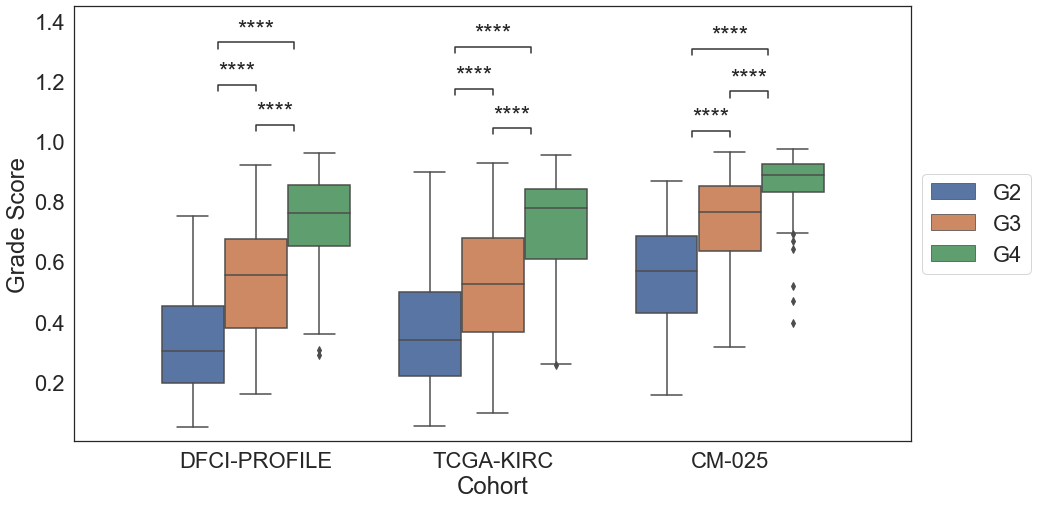

In [29]:
# %%capture
set_rc(15,8, 2)
sns.set_style('white')

data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()
data['cohort'] = data['cohort'].replace({'KIRC':'TCGA-KIRC','CM025':'CM-025','PROFILE':'DFCI-PROFILE'})

x = 'cohort'
y = 'updated_nonstroma_grade_mean'
hue = 'grade'

hue_order = ['G2','G3','G4']
order = [x.upper() for x in ['dfci-profile','tcga-kirc','cm-025',]]
box_pairs = []
[box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in ['TCGA-KIRC','CM-025','DFCI-PROFILE']]


g = sns.boxplot(x=x, order=order, hue=hue, hue_order=hue_order, y=y, data=data)
move_leg(g, x=1)
test_results = add_stat_annotation(g, data=data, x=x, y=y, hue=hue,
                                   box_pairs=box_pairs,
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2)
test_results

plt.ylabel('Grade Score')
plt.xlabel('Cohort')


plt.savefig(f'./20230427_regen_{y}_vs_{hue}_all_cohorts_signif_test_marker_wide_box.pdf', bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DFCI-PROFILE
 Train Cohort_G4 v.s. DFCI-PROFILE
 Train Cohort_G3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.688e-10 U_stat=5.379e+03
TCGA-KIRC
 Test Cohort_G2 v.s. TCGA-KIRC
 Test Cohort_G4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.011e-18 U_stat=1.374e+03
CM-025
 Test Cohort_G4 v.s. CM-025
 Test Cohort_G3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.502e-09 U_stat=5.425e+03
CM-025
 Test Cohort_G2 v.s. CM-025
 Test Cohort_G4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.605e-19 U_stat=3.120e+02
DFCI-PROFILE
 Train Cohort_G2 v.s. DFCI-PROFILE
 Train Cohort_G4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.683e-20 U_stat=3.620e+02
TCGA-KIRC
 Test Cohort_G4 v.s. TCGA-KIRC
 Test Cohor

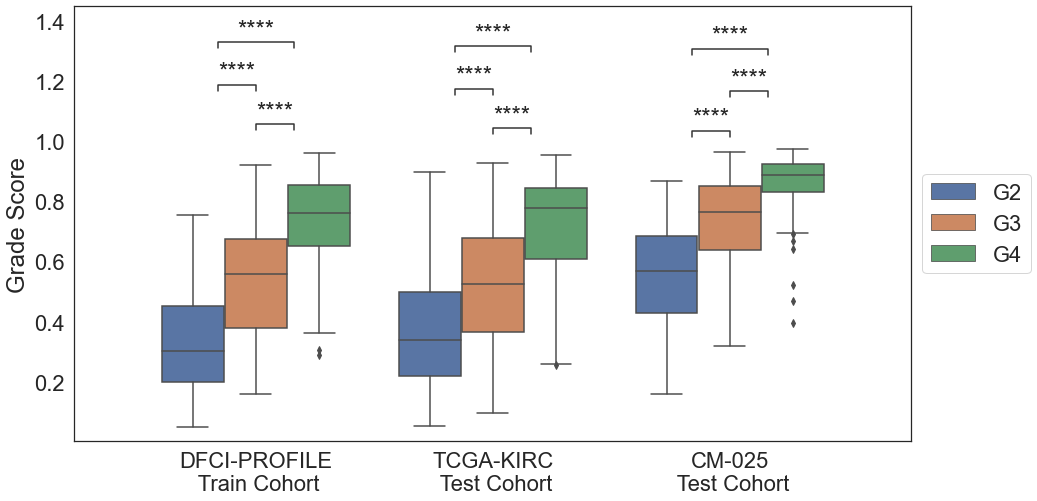

In [30]:
# %%capture
set_rc(15,8, 2)
sns.set_style('white')

data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()
data['cohort'] = data['cohort'].replace({'KIRC':'TCGA-KIRC\n Test Cohort','CM025':'CM-025\n Test Cohort','PROFILE':'DFCI-PROFILE\n Train Cohort'})

x = 'cohort'
y = 'updated_nonstroma_grade_mean'
hue = 'grade'

hue_order = ['G2','G3','G4']
order = ['DFCI-PROFILE\n Train Cohort', 'TCGA-KIRC\n Test Cohort', 'CM-025\n Test Cohort']
box_pairs = []
[box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in order]


g = sns.boxplot(x=x, order=order, hue=hue, hue_order=hue_order, y=y, data=data)
move_leg(g, x=1)
test_results = add_stat_annotation(g, data=data, x=x, y=y, hue=hue,
                                   box_pairs=box_pairs,
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2)
test_results

plt.ylabel('Grade Score')
plt.xlabel('')


plt.savefig(f'./20230427_regen_{y}_vs_{hue}_all_cohorts_signif_test_marker_wide_box_alt.pdf', bbox_inches='tight')